## Import libraries, create connection with db

In [51]:
import psycopg2
from psycopg2 import sql
import psycopg2.extras
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()

def connect_to_db():
    try:
        conn = psycopg2.connect(host=os.getenv('DB_HOST'), port=os.getenv('DB_PORT'), database=os.getenv('DB_NAME'), user=os.getenv('DB_USER'), password=os.getenv('DB_PASS'))
        cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
        return conn, cur
    except:
        print("Unable to connect to the database")

### Closing prices for selected symbols over time to observe trends

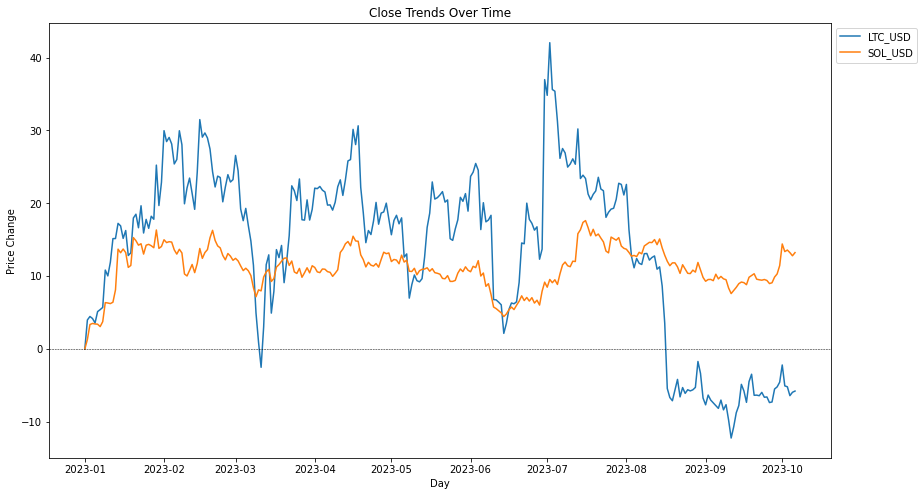

In [38]:
# Connect and query the data
conn, cursor = connect_to_db()
query = sql.SQL("""
    SELECT  symbol, 
            LAST(close, timestamp) AS close, 
            time_bucket('1 day', timestamp) AS day
    FROM trades
    WHERE timestamp > '2023-01-01'
    GROUP BY day, symbol;
""")    
cursor.execute(query)
results = cursor.fetchall()

# Save the results to a dataframe
df = pd.DataFrame(results, columns=['symbol', 'close', 'day'])
df['day'] = pd.to_datetime(df['day'])
df = df.pivot(index='day', columns='symbol', values='close')
df = df.transform(lambda x: x - x.iloc[0])      # Normalize the data for trend comparison

# Plot the trends
def plot_trends(df, symbols):
    plt.figure(figsize=(14, 8))
    for symbol in df.columns:
        if symbol in symbols:
            plt.plot(df.index, df[symbol], label=symbol)
    plt.xlabel('Day')
    plt.ylabel('Price Change')
    plt.title('Close Trends Over Time')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

symbols = ['LTC_USD', 'SOL_USD']
plot_trends(df, symbols)



### Volume analysis over time

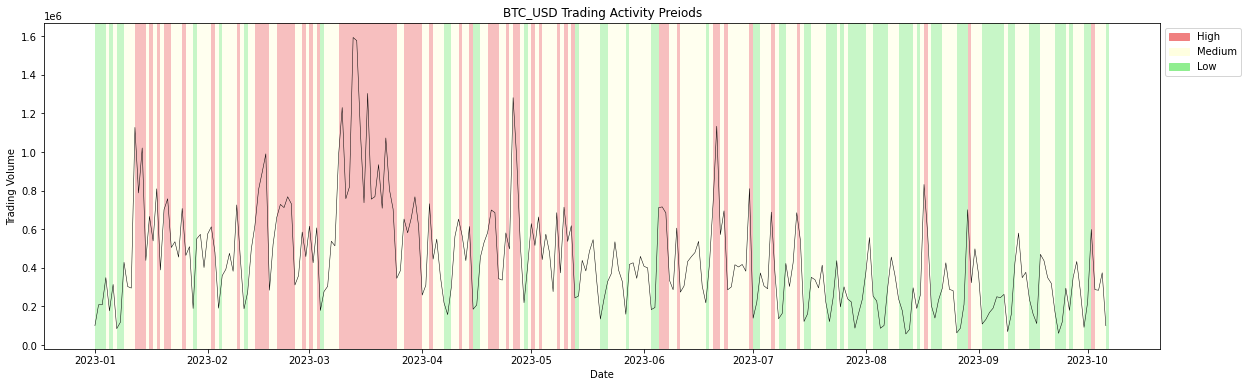

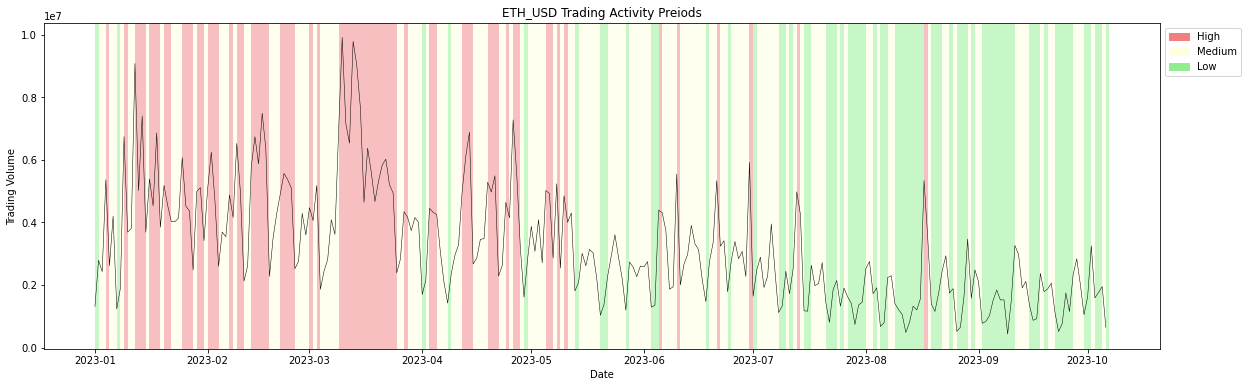

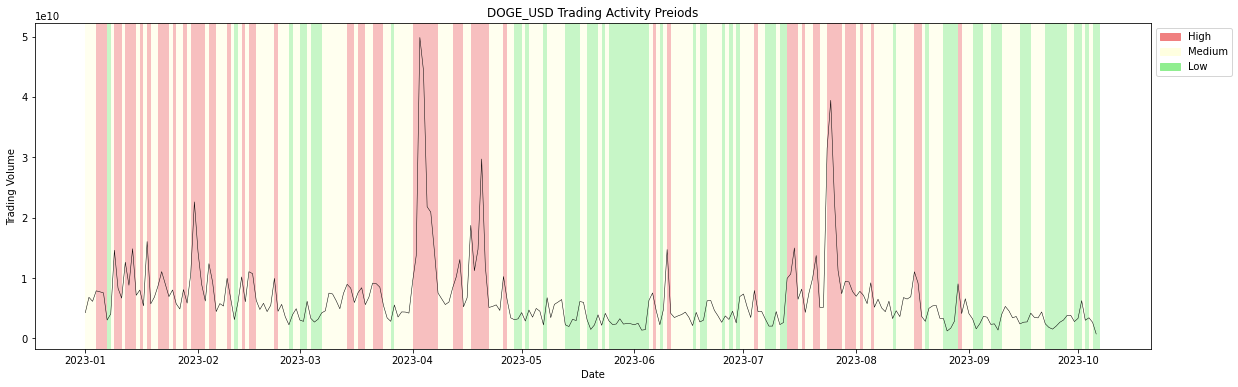

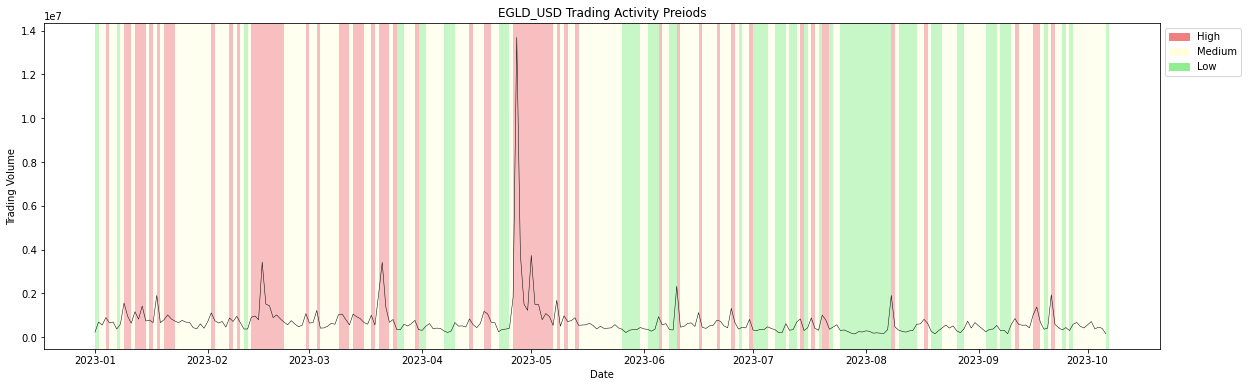

In [73]:
# Connect and query the data of total volume per day for the selected symbols in the last year
symbols = ['BTC_USD', 'ETH_USD', 'DOGE_USD', 'EGLD_USD']

conn, cursor = connect_to_db()
query = sql.SQL(f'''
    SELECT  symbol, 
            SUM(volume) AS volume, 
            time_bucket('1 day', timestamp) AS day
    FROM trades
    WHERE timestamp > '2023-01-01' AND symbol in ({str(symbols)[1:-1]})
    GROUP BY day, symbol;
''')    
cursor.execute(query)
results = cursor.fetchall()

# Save the results to a dataframe
df = pd.DataFrame(results, columns=['symbol', 'volume', 'day'])
df['day'] = pd.to_datetime(df['day'])
df = df.pivot(index='day', columns='symbol', values='volume')
for symbol in symbols:
    df[symbol] = df[symbol].astype(float)
    
# Analyze the data
# I define a period of high trading activity as the time when the volume is above the 75th percentile
# I define a period of low trading activity as the time when the volume is below the 25th percentile
# I define a period of normal trading activity as the time when the volume is between the 25th and 75th percentile

for symbol in symbols:
    lower_quartile = df[symbol].quantile(0.25)
    upper_quartile = df[symbol].quantile(0.75)

    # Categorize trading activity from volume
    column_name = symbol + '_activity'
    df[column_name] = 'Medium'
    df.loc[df[symbol] < lower_quartile, column_name] = 'Low'
    df.loc[df[symbol] > upper_quartile, column_name] = 'High'

# Plot the data
def plot_activity_periods(df, symbol):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(df.index, df[symbol], label=symbol, color='black', linewidth=0.5)
    colors = {'High': 'lightcoral', 'Medium': 'lightyellow', 'Low': 'lightgreen'}
    for date, activity in df[symbol+'_activity'].items():
        ax.axvspan(date, date + pd.DateOffset(days=1), facecolor=colors[activity], alpha=0.5)
        ax.legend()
        ax.set_xlabel('Date')
        ax.set_ylabel('Trading Volume')
        ax.set_title(symbol+' Trading Activity Preiods')
        
        # Legend for trading acativity periods
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in colors]
        labels = ['High', 'Medium', 'Low']
        plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
for symbol in symbols:
    plot_activity_periods(df, symbol)
        

### Market Overview Daily Analysis

In [103]:
# Connect and query the data
start_date = '2023-05-05'
end_date = '2023-05-10'

conn, cursor = connect_to_db()
query = sql.SQL(f'''
    SELECT  SUM(volume) AS total_volume,
            SUM(close) AS total_close,
            time_bucket('1 hour', timestamp) AS hour
    FROM trades
    WHERE timestamp >= '{start_date}' AND timestamp < '{end_date}' 
    GROUP BY hour;
''')    
cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=['total_volume', 'total_close', 'hour'])
df['hour'] = pd.to_datetime(df['hour'])
df = df.set_index('hour')
df = df.sort_index(ascending=True)
print(df)


                            total_volume  total_close
hour                                                 
2023-05-05 00:00:00+00:00  154460084.366  31369.25827
2023-05-05 01:00:00+00:00  201518433.492  31470.49523
2023-05-05 02:00:00+00:00  492267479.614  31884.65811
2023-05-05 03:00:00+00:00  345663182.910  31801.19191
2023-05-05 04:00:00+00:00  184006782.591  31752.30538
...                                  ...          ...
2023-05-09 19:00:00+00:00  252706343.970  30031.39589
2023-05-09 20:00:00+00:00  215942909.716  30201.30762
2023-05-09 21:00:00+00:00  234041644.482  30126.65180
2023-05-09 22:00:00+00:00  138341247.583  30074.33654
2023-05-09 23:00:00+00:00  139501002.868  30049.60935

[120 rows x 2 columns]


**Plot daily behaviour of volume and close values for all trading pairs**

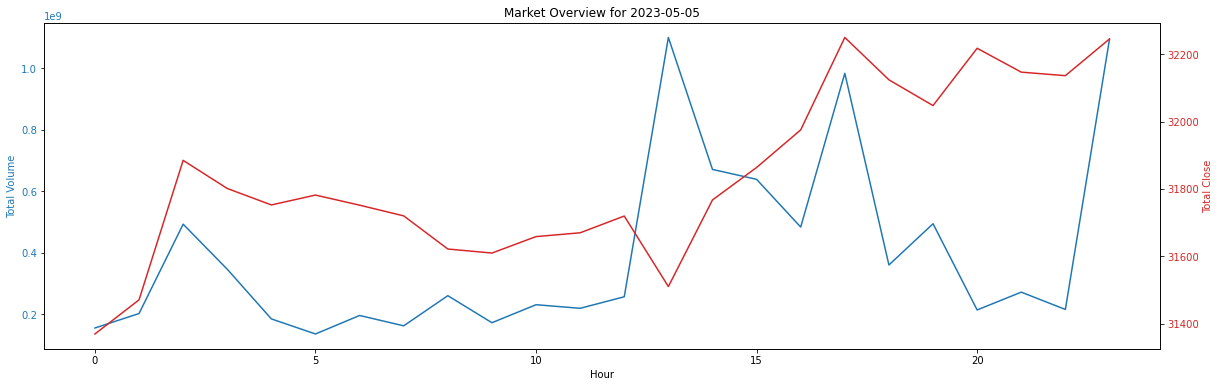

In [101]:
def plot_daily_behaviour(df, date):
    selected_day_df = df[df.index.date == pd.to_datetime(date).date()]
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plot total volume on the left y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Total Volume', color=color)
    ax1.plot(selected_day_df.index.hour, selected_day_df['total_volume'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a secondary y-axis for total close on the right
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Close', color=color)
    ax2.plot(selected_day_df.index.hour, selected_day_df['total_close'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and show the plot
    plt.title(f'Market Overview for {date}')
    plt.show()

plot_daily_behaviour(df, '2023-05-05')

**Plot behaviour of trading volume for different days in the week**

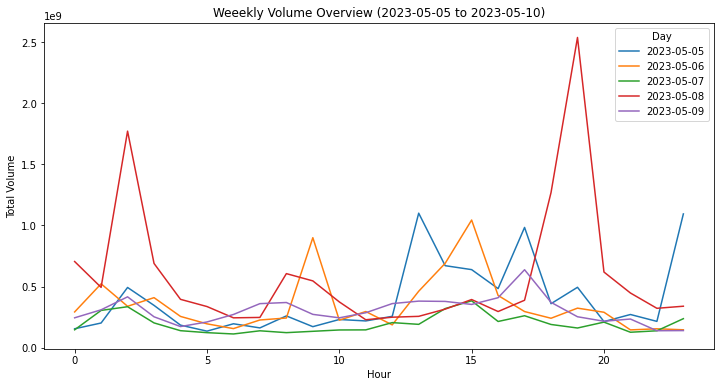

In [102]:
def plot_weekly_volume(df, start_date, end_date):
    weekly_df = df[(df.index.date >= pd.to_datetime(start_date).date()) & (df.index.date <= pd.to_datetime(end_date).date())]
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Iterate over each day and plot total volume
    for day, day_df in weekly_df.groupby(weekly_df.index.date):
        ax.plot(day_df.index.hour, day_df['total_volume'], label=str(day))

    ax.set_title(f'Weeekly Volume Overview ({start_date} to {end_date})')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Total Volume')
    ax.legend(title='Day')
    plt.show()
    
plot_weekly_volume(df, start_date, end_date)

**Plot total trading volume behaviour for concurrent mondays, with normalized data per day**

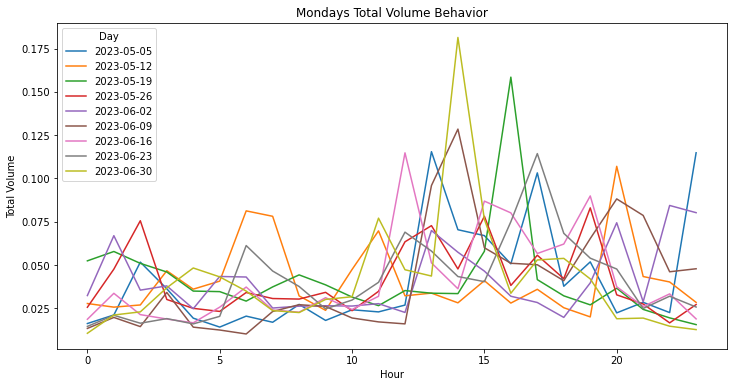

In [117]:
# Connect and query the data
mondays = ['2023-05-05', '2023-05-12', '2023-05-19', '2023-05-26', '2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23', '2023-06-30']
end_date = '2023-07-01'

conn, cursor = connect_to_db()
query = sql.SQL(f'''
    SELECT  SUM(volume) AS total_volume,
            SUM(close) AS total_close,
            time_bucket('1 hour', timestamp) AS hour
    FROM trades
    WHERE timestamp >= '{mondays[0]}' AND timestamp < '{end_date}'
    GROUP BY hour;
''')    
cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=['total_volume', 'total_close', 'hour'])
df['hour'] = pd.to_datetime(df['hour'])
df = df.set_index('hour')
df = df.sort_index(ascending=True)

def normalize_volume_by_day(df):
    df['date'] = df.index.date
    
    # Calculate the sum of total_volume for each day
    daily_volume_sum = df.groupby('date')['total_volume'].sum()

    # Normalize total_volume by dividing each value by the daily sum
    df['normalized_volume'] = df['total_volume'] / df['date'].map(daily_volume_sum)
    return df

df = normalize_volume_by_day(df)

def plot_mondays_behaviour(df, mondays):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Iterate over each Monday and plot total volume
    for monday in mondays:
        monday_df = df[df.index.date == pd.to_datetime(monday).date()]
        ax.plot(monday_df.index.hour, monday_df['normalized_volume'], label=str(monday))

    ax.set_title('Mondays Total Volume Behavior')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Total Volume')
    ax.legend(title='Day')

    plt.show()

plot_mondays_behaviour(df, mondays)